# Fine-tune SAM (segment Anything Model) on a Custom Dataset

Notebook ini akan melakukan fine-tuning SAM (Segment Anything Model) pada dataset kustom. Apakah Anda bekerja pada analisis citra medis, citra satelit, atau tugas segmentasi khusus domain lainnya, proses menyesuaikan model yang sudah dilatih sebelumnya dengan kebutuhan spesifik Anda adalah langkah yang krusial. Dalam tutorial ini, kami akan menggunakan dataset sederhana, Segmentasi Lubang Jalan dengan gambar kecil, tetapi dari sini Anda dapat mengembangkannya ke dataset yang lebih besar.

## Set-up environment

Pertama, kita instal 🤗 Transformers dan 🤗 Datasets.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load dataset

Di sini, kita memuat dataset kecil yang terdiri dari 84 pasangan (gambar, masker kebenaran dasar).

Untuk memuat gambar dan masker Anda sendiri, Anda harus mengunggah dataset Anda ke Hugging Face Hub dengan mengikuti tutorial berikut: [https://huggingface.co/docs/transformers/tasks/semantic_segmentation#custom-dataset](https://huggingface.co/docs/transformers/tasks/semantic_segmentation#custom-dataset).

In [3]:
from datasets import load_dataset

dataset = load_dataset("hf-vision/road-pothole-segmentation")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/424 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.25M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/79 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 79
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5
    })
})

Kita bisa visualiasi sebagai contoh:

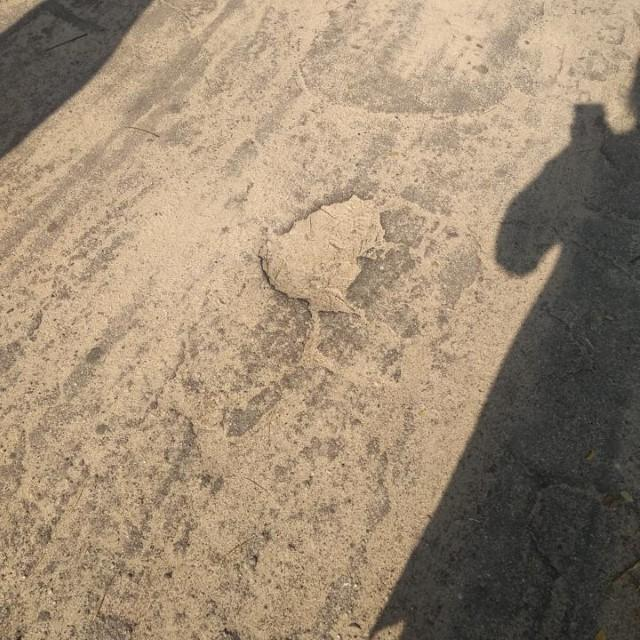

In [5]:
example = dataset["train"][1]
example
image = example["image"]
image

(-0.5, 639.5, 639.5, -0.5)

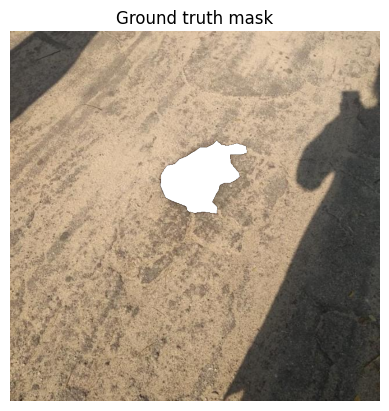

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Create PyTorch Dataset

Dalam proses pembuatan dataset PyTorch, kita mendefinisikan struktur dataset reguler yang mengorganisir data untuk model. Setiap contoh dalam dataset ini terdiri dari:

*   Nilai piksel, yang mewakili gambar yang disiapkan untuk model.
*   Sebuah prompt kotak pembatas yang diberikan dalam bentuk prompt.
*   Sebuah masker segmentasi kebenaran dasar.

Penting untuk dicatat bahwa SAM, model yang dibahas, selalu dilatih menggunakan "prompt" tertentu. Prompt ini dapat berupa kotak pembatas, titik, teks, atau masker sederhana. Tujuan pelatihan adalah agar model dapat belajar dan menghasilkan masker yang sesuai dengan gambar dan prompt yang diberikan.

Untuk memfasilitasi pembuatan prompt kotak pembatas berdasarkan segmentasi kebenaran dasar, sebuah fungsi didefinisikan di bawah ini. Fungsi ini telah diadaptasi dari [sumber ini](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29). Langkah ini sangat penting dalam mempersiapkan input yang diperlukan untuk model selama proses pelatihan.

In [7]:
def get_bounding_box(ground_truth_map):
  # mendapatkan kotak pembatas dari masker
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)

  # menambahkan gangguan pada koordinat kotak pembatas
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [8]:
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

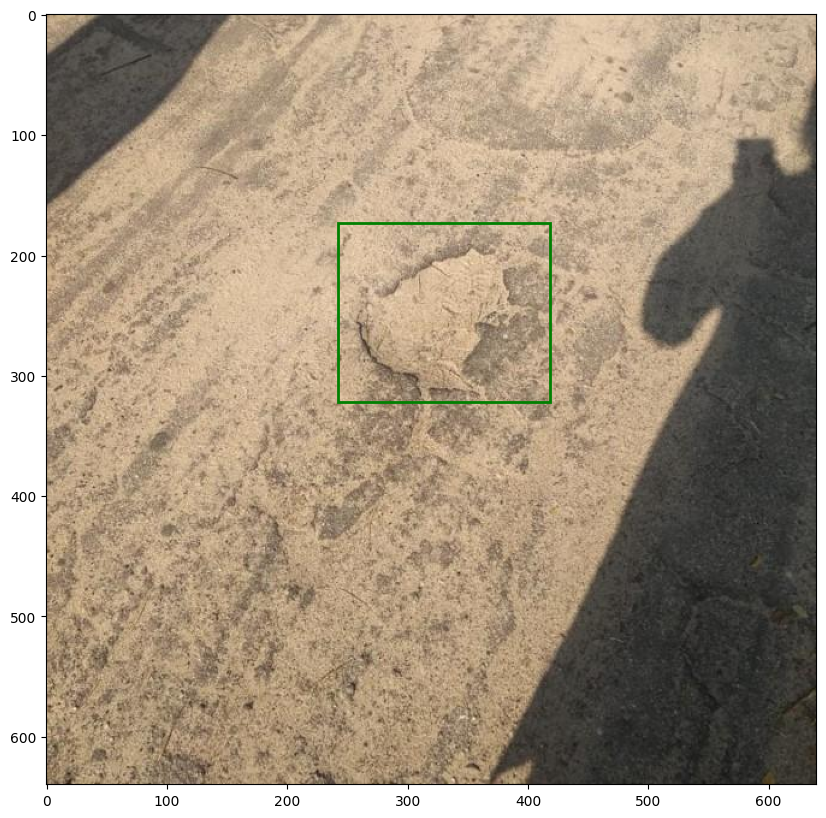

In [9]:
input_boxes = get_bounding_box(ground_truth_seg)
input_boxes
show_boxes_on_image(image, [input_boxes])

Dataset kustom ini mengambil daftar sampel (masing-masing berisi gambar dan label) dan objek pemroses saat inisialisasi. Setelah inisialisasi, metode `__getitem__` memproses gambar dan masker kebenaran dasar, menormalkan masker, mengekstrak prompt kotak pembatas, dan mempersiapkan input untuk model.  
Input yang telah diproses mencakup gambar, prompt, dan masker kebenaran dasar dalam format kamus.

In [10]:
from torch.utils.data import Dataset
import cv2

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # menormalkan masker
    ground_truth_mask = ground_truth_mask / 255.0

    # mendapatkan prompt kotak pembatas
    prompt = get_bounding_box(ground_truth_mask)

    # mempersiapkan gambar dan prompt untuk model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # menghapus dimensi batch yang ditambahkan oleh pemroses secara default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # menambahkan segmentasi kebenaran dasar
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [11]:
from transformers import SamProcessor

# Memuat pemroses dari SAM resmi
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [12]:
# Membagi dataset menjadi pelatihan dan validasi
train_dataset = SAMDataset(dataset=dataset["train"], processor=processor)
validation_dataset = SAMDataset(dataset=dataset["validation"], processor=processor)

In [13]:
# Di sini kita memeriksa bentuk dari sampel dataset pelatihan
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (640, 640)


/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


## Create PyTorch DataLoader

Selanjutnya, kita mendefinisikan PyTorch Dataloader, yang memungkinkan kita untuk mengambil batch dari dataset.



In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 640, 640])


In [16]:
batch["pixel_values"].shape

torch.Size([2, 3, 1024, 1024])

In [17]:
batch["ground_truth_mask"].shape

torch.Size([2, 640, 640])

## Load the model

In [18]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# pastikan kita hanya menghitung gradien untuk dekoder masker
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [19]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

## Train the model

In [20]:
from torch.optim import Adam
import torchvision

# Catatan: Penalaan hiperparameter dapat meningkatkan kinerja di sini
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

In [21]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch import nn


num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

      # pass maju
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # hitung loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      predicted_masks = nn.functional.interpolate(predicted_masks,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)

      ground_truth_masks = batch["ground_truth_mask"].float().to(device)

      loss = torchvision.ops.sigmoid_focal_loss(predicted_masks, ground_truth_masks.unsqueeze(1), reduction='mean')

      # pass mundur (hitung gradien parameter terhadap loss)
      optimizer.zero_grad()
      loss.backward()

      # optimasi
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Rata-rata loss: {mean(epoch_losses)}')

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 40/40 [00:38<00:00,  1.05it/s]


EPOCH: 0
Rata-rata loss: 0.012647353688953445


100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


EPOCH: 1
Rata-rata loss: 0.007994551822775975


100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


EPOCH: 2
Rata-rata loss: 0.006427760465885513


100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


EPOCH: 3
Rata-rata loss: 0.005616990505950525


100%|██████████| 40/40 [00:42<00:00,  1.06s/it]


EPOCH: 4
Rata-rata loss: 0.005270298858522438


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]


EPOCH: 5
Rata-rata loss: 0.005094717015163041


100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


EPOCH: 6
Rata-rata loss: 0.0049089582709711975


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]


EPOCH: 7
Rata-rata loss: 0.004724336904473603


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]


EPOCH: 8
Rata-rata loss: 0.004559886490460486


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]

EPOCH: 9
Rata-rata loss: 0.004368038081156556


## Inference

Sebagai contoh inferensi, kita dapat mengambil gambar validasi acak.

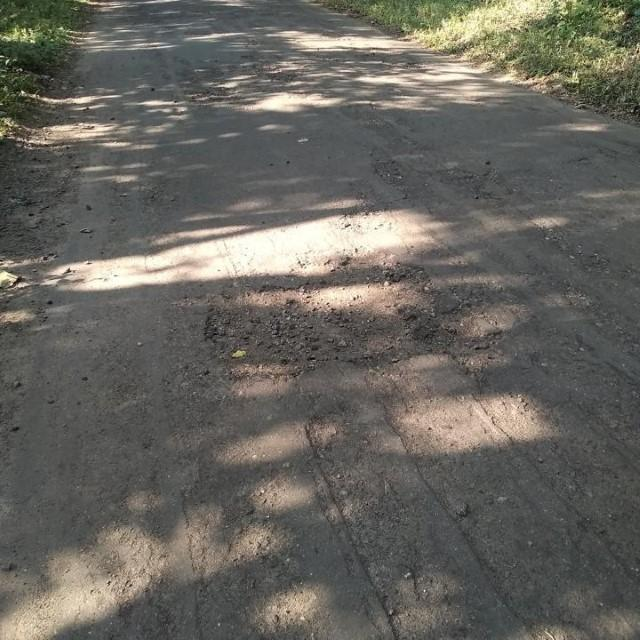

In [22]:
import numpy as np
from PIL import Image

# mari ambil contoh validasi acak
idx = 4

# memuat gambar
image = dataset["validation"][idx]["image"]
image

In [23]:
# mendapatkan prompt kotak berdasarkan peta segmentasi kebenaran dasar
ground_truth_mask = np.array(dataset["validation"][idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# mempersiapkan gambar + prompt kotak untuk model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


Mulai evaluasi model dengan gambar baru.

In [24]:
model.eval()

# pass maju
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [25]:
# menerapkan sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# mengubah ukuran masker ke ukuran semula
sam_seg_prob = nn.functional.interpolate(sam_seg_prob,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)

# mengonversi masker lunak menjadi masker keras
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
sam_segmentation_results = (sam_seg_prob > 0.5).astype(np.uint8)

In [26]:
sam_segmentation_results.shape

(640, 640)

In [27]:
ground_truth_mask.shape

(640, 640)

(-0.5, 639.5, 639.5, -0.5)

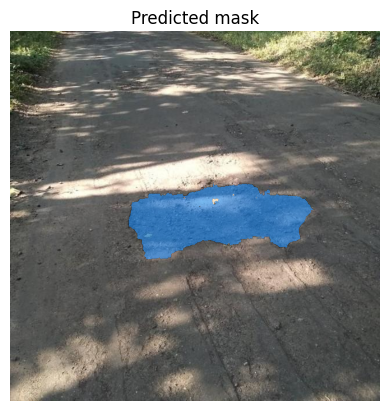

In [28]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(sam_segmentation_results, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Bandingkan ini dengan segmentasi kebenaran dasar:

(-0.5, 639.5, 639.5, -0.5)

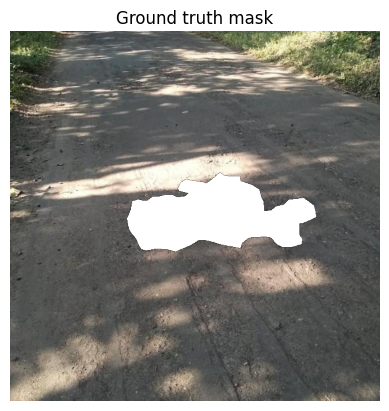

In [29]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

# Push the model to Hugging Face Hub

Setelah pelatihan selesai, Anda dapat mengunggah model Anda ke 🤗 Hub dan membagikannya dengan komunitas. Pertama, masuk dengan kunci Anda dan gunakan sintaks `push_to_hub` di bawah ini.

In [30]:
from huggingface_hub import notebook_login

notebook_login()

In [34]:
model.push_to_hub("khaliiishah/huggingface_khalishah")

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/khaliiishah/huggingface_khalishah/commit/a5dee881ae9793f387c604f44cad8d435a4cde5f', commit_message='Upload model', commit_description='', oid='a5dee881ae9793f387c604f44cad8d435a4cde5f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/khaliiishah/huggingface_khalishah', endpoint='https://huggingface.co', repo_type='model', repo_id='khaliiishah/huggingface_khalishah'), pr_revision=None, pr_num=None)